In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install -U qdrant_client

In [28]:
import os
from dotenv import load_dotenv
import openai
from PIL import Image
import matplotlib.pyplot as plt

#Setting up enviorment variables
load_dotenv()
open_api_key=os.environ['OPENAI_API_KEY']
openai.api_key=open_api_key


### Plot input images


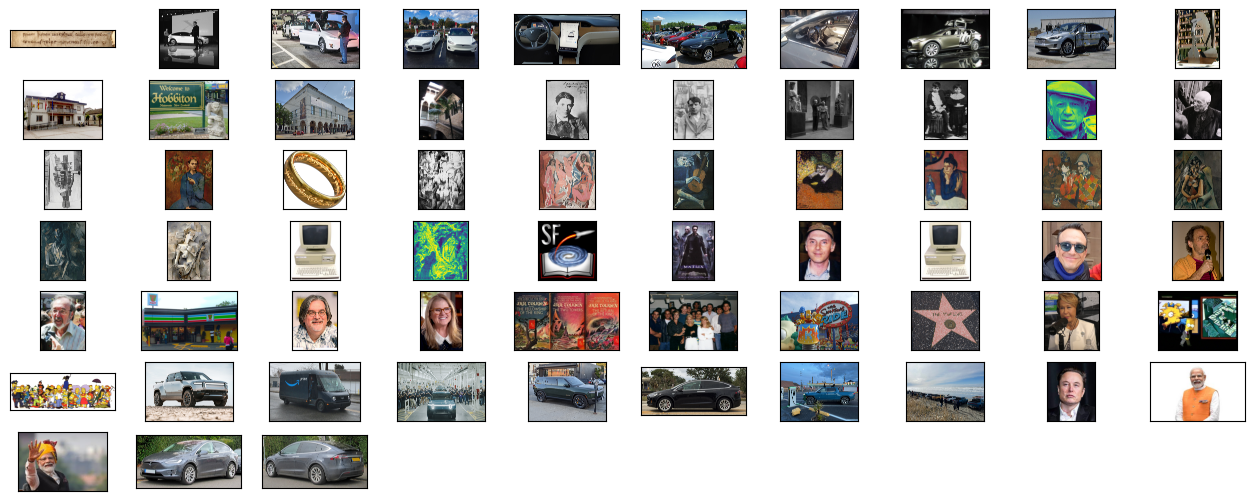

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
import os

image_paths = []
for img_path in os.listdir("./mixed_wiki"):
    image_paths.append(str(os.path.join("./mixed_wiki", img_path)))


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(10, 10, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 63:
                break


plot_images(image_paths)

### Build Multi-modal index and vector store to index both text and images


In [30]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import QdrantVectorStore
from llama_index import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index import (
    SimpleDirectoryReader,
)


# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="qdrant_mm_db_3")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection"
)
storage_context = StorageContext.from_defaults(vector_store=text_store)

# Create the MultiModal index
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents, storage_context=storage_context, image_vector_store=image_store
)

# Save it
# index.storage_context.persist(persist_dir="./storage")

# # Load it
# from llama_index import load_index_from_storage

# storage_context = StorageContext.from_defaults(
#     vector_store=text_store, persist_dir="./storage"
# )
# index = load_index_from_storage(storage_context, image_store=image_store)

### Retrieve and query texts and images from our Multi-Modal Index

1. Multi-Modal RAG Querying

In [31]:
from llama_index.prompts import PromptTemplate
from llama_index.query_engine import SimpleMultiModalQueryEngine

qa_tmpl_str = (
    "Context information is below.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Given the context information and not prior knowledge, "
    "answer the query.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = index.as_query_engine(
    multi_modal_llm=openai_mm_llm, text_qa_template=qa_tmpl
)



In [32]:
query_str = "Tell me more about ElonMusk"
response = query_engine.query(query_str)
response.metadata['text_nodes']

[NodeWithScore(node=TextNode(id_='6ad1877c-a64a-4c9a-8c77-b63bea3706fb', embedding=None, metadata={'file_path': 'mixed_wiki\\Elon Musk.txt', 'file_name': 'Elon Musk.txt', 'file_type': 'text/plain', 'file_size': 3893, 'creation_date': '2023-11-27', 'last_modified_date': '2023-11-27', 'last_accessed_date': '2023-11-27'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='11aa160a-f0c0-4e53-9568-5c9e2a050104', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'mixed_wiki\\Elon Musk.txt', 'file_name': 'Elon Musk.txt', 'file_type': 'text/plain', 'file_size': 3893, 'creation_date': '2023-11-27', 'last_modified_date': '2023-11-27', 'last_accessed_date': '2023-11-27'}, hash='37166aea03931ea991f16746cc0e3626

In [33]:
print(str(response))


Elon Musk is a prominent entrepreneur known for his work in revolutionizing several industries. After his initial success with Zip2 and PayPal, Musk has gone on to found and lead groundbreaking companies.

SpaceX, his aerospace manufacturer and space transport company, focuses on making space travel more affordable and ultimately aiming for the colonization of Mars. SpaceX has achieved significant milestones like launching the Falcon and Dragon spacecraft and has become renowned for its reusable rockets, drastically reducing the cost of space access.

Tesla, Inc. is another major venture established by Musk to accelerate the adoption of sustainable energy. Through Tesla, Musk has made significant contributions to the electric vehicle (EV) industry, not only with high-performance electric cars but also through large-scale battery production and advanced driver-assistance systems.

With Neuralink, Musk is venturing into the field of neurotechnology, aiming to develop brain–computer inter

**Node ID:** 6ad1877c-a64a-4c9a-8c77-b63bea3706fb<br>**Similarity:** 0.8580974770182632<br>**Text:** Elon Musk is a visionary entrepreneur and business magnate known for his ambitious pursuits in various industries, including space exploration, electric vehicles, renewable energy, and neuroscience...<br>

**Node ID:** 03fd54e0-de26-4f18-b6a8-469356d72bde<br>**Similarity:** 0.8344634370430678<br>**Text:** Elon Musk, a visionary entrepreneur, is transforming multiple industries. As CEO of Tesla, he pioneers electric vehicles, advancing sustainable transport. With SpaceX, Musk envisions space travel a...<br>

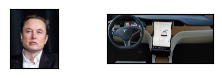

In [34]:
# show sources
from llama_index.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)

In [35]:
query_str = "Tell me more about Narendra Modi"
response = query_engine.query(query_str)
response.metadata['text_nodes']

[NodeWithScore(node=TextNode(id_='f46709f0-03ae-4ead-879e-8248f93b7c08', embedding=None, metadata={'file_path': 'mixed_wiki\\Naredra Modi.txt', 'file_name': 'Naredra Modi.txt', 'file_type': 'text/plain', 'file_size': 3901, 'creation_date': '2023-11-27', 'last_modified_date': '2023-11-27', 'last_accessed_date': '2023-11-27'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='8406a933-6472-44f3-be2f-aea512dcb950', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'mixed_wiki\\Naredra Modi.txt', 'file_name': 'Naredra Modi.txt', 'file_type': 'text/plain', 'file_size': 3901, 'creation_date': '2023-11-27', 'last_modified_date': '2023-11-27', 'last_accessed_date': '2023-11-27'}, hash='edc869289e12264fafa7

In [36]:
response.metadata['image_nodes']

[NodeWithScore(node=ImageNode(id_='6ec1ef51-5768-44e5-877d-5e1b6181b8a5', embedding=None, metadata={'file_path': 'mixed_wiki\\64.jpg', 'file_name': '64.jpg', 'file_type': 'image/jpeg', 'file_size': 6080, 'creation_date': '2023-11-27', 'last_modified_date': '2023-11-27', 'last_accessed_date': '2023-11-27'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='87918b85-90e2-45e0-858b-4b5e85494856', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': 'mixed_wiki\\64.jpg', 'file_name': '64.jpg', 'file_type': 'image/jpeg', 'file_size': 6080, 'creation_date': '2023-11-27', 'last_modified_date': '2023-11-27', 'last_accessed_date': '2023-11-27'}, hash='453ae47acfc97e350c5b8763d38a5d9fb1b8d42725d49ac6a475f8e086a

**Node ID:** f46709f0-03ae-4ead-879e-8248f93b7c08<br>**Similarity:** 0.87292558513933<br>**Text:** Narendra Modi, born on September 17, 1950, is an Indian politician who has left an indelible mark on the country's political landscape. His journey from a humble background to becoming the 14th Pri...<br>

**Node ID:** 03fd54e0-de26-4f18-b6a8-469356d72bde<br>**Similarity:** 0.8367714273271686<br>**Text:** Elon Musk, a visionary entrepreneur, is transforming multiple industries. As CEO of Tesla, he pioneers electric vehicles, advancing sustainable transport. With SpaceX, Musk envisions space travel a...<br>

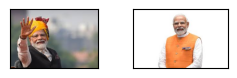

In [37]:
# show sources
from llama_index.response.notebook_utils import display_source_node

for text_node in response.metadata["text_nodes"]:
    display_source_node(text_node, source_length=200)
plot_images(
    [n.metadata["file_path"] for n in response.metadata["image_nodes"]]
)